# Generating noise and colouring it with provided PSD

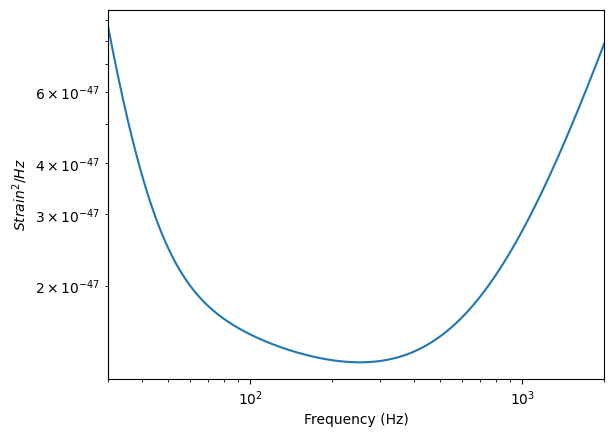

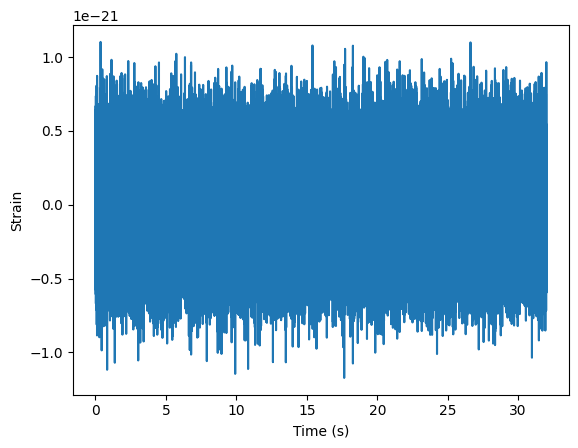

In [11]:
import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd
import pycbc.filter
from pycbc.waveform import get_td_waveform
import numpy as np

# The color of the noise matches a PSD which you provide
flow = 30.0
delta_f = 1.0 / 16
flen = int(2048 / delta_f) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)


pp.plot(psd.sample_frequencies,psd.data)
pp.loglog()
pp.xlim(30,2000)
pp.ylabel('$Strain^2 / Hz$')
pp.xlabel('Frequency (Hz)')
pp.show()


# Generate 32 seconds of noise at 4096 Hz
delta_t = 1.0 / 4096
tsamples = int(32/ delta_t)
ts = pycbc.noise.gaussian.noise_from_psd(tsamples,delta_t, psd, seed=127)


pp.plot(ts.sample_times, ts)
pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.show()

# Generating strain

fp=0.5494252193754385, fc=-0.5320202660769405


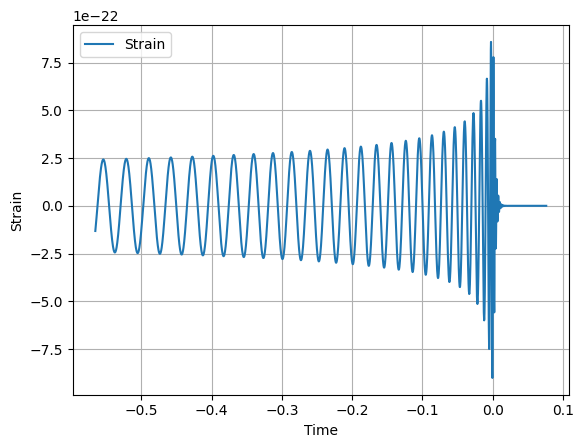

In [2]:
from pycbc.detector import Detector
from pycbc.waveform import get_td_waveform

# Time, orientation and location of the source in the sky
ra = 1.7
dec = 1.7
pol = 0.2
inc = 0
time = 0

# We can calcualate the antenna pattern for Hanford at
# the specific sky location
d = Detector("H1")

# We get back the fp and fc antenna pattern weights.
fp, fc = d.antenna_pattern(ra, dec, pol, time)
print("fp={}, fc={}".format(fp, fc))

# These factors allow us to project a signal into what the detector would observe


## Generate a waveform
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt", mass1=20, mass2=20,
                         f_lower=30, delta_t=1.0/4096, inclination=inc,
                         distance=400)

## Apply the factors to get the detector frame strain
ht = fp * hp + fc * hc



pp.plot(ht.sample_times, ht, label='Strain')
pp.legend()
pp.ylabel('Strain')
pp.xlabel('Time')
pp.grid()
pp.show()

In [3]:
print (ht.start_time)
print (ht.end_time)
print(ht.duration)


-0.565628307
0.076461537
0.64208984375


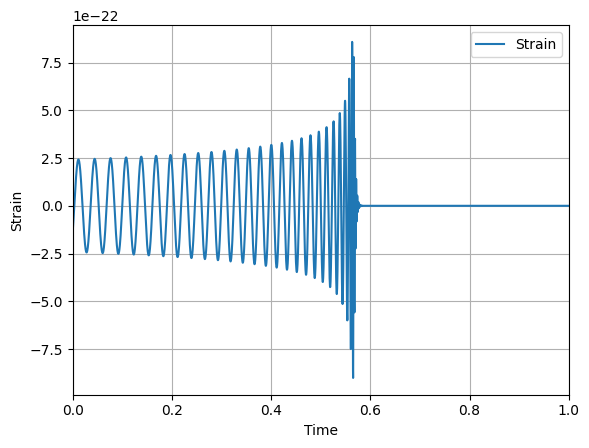

32.0


In [13]:
ht.resize(len(ts))                                   #Resizing the strain to noise time series
pp.plot(ht.sample_times, ht, label='Strain')
pp.legend()
pp.xlim(0,1)
pp.xlabel('Time')
pp.ylabel('Strain')
pp.grid()
pp.show()
print(ht.duration)

0
32
32.0


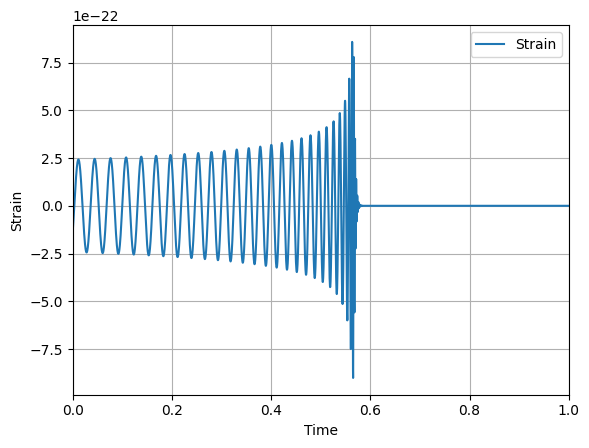

In [14]:
ht.start_time = ts.start_time
print (ht.start_time)
print (ht.end_time)
print(ht.duration)


pp.plot(ht.sample_times, ht, label='Strain')
pp.legend()
pp.xlim(0,1)
pp.ylabel('Strain')
pp.xlabel('Time')
pp.grid()
pp.show()

# Injecting signal into noise

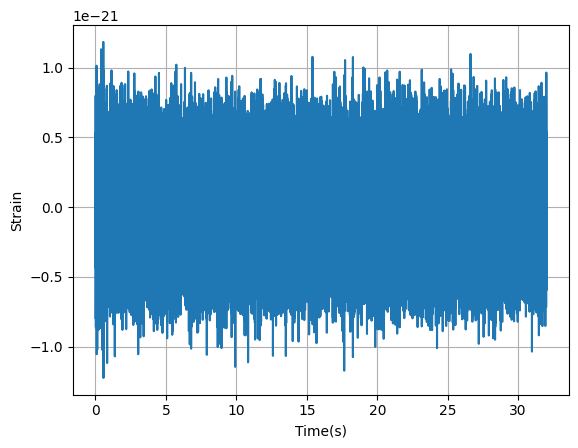

In [6]:
ts = ts.add_into(ht)                   #s(t)=n(t)+h(t)

pp.plot(ts.sample_times, ts)
pp.xlabel('Time(s)')
pp.ylabel('Strain')
pp.grid()
pp.show()

# Calculating the power spectral density

(30, 1024)

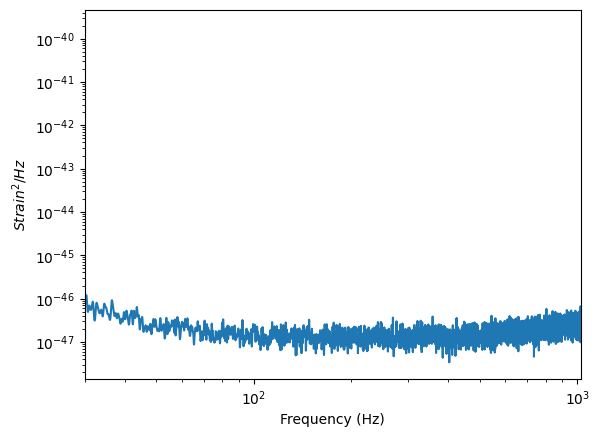

In [7]:
conditioned = ts

from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner

psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 30 Hz, and will have low values
# below this we need to informat the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=30)

pp.loglog(psd.sample_frequencies, psd)
pp.ylabel('$Strain^2 / Hz$')
pp.xlabel('Frequency (Hz)')
pp.xlim(30, 1024)

# Generating template for matched filtering

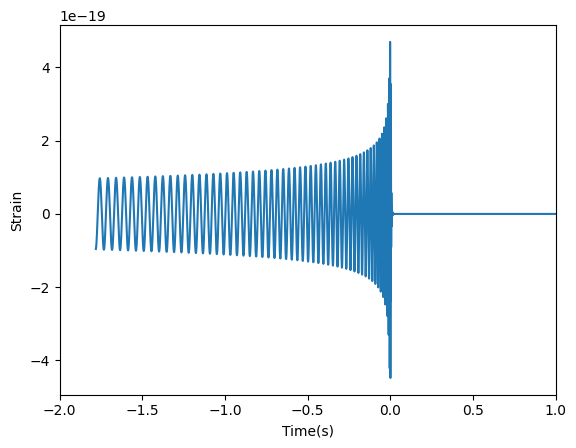

-1.780887602
30.219112398
32.0


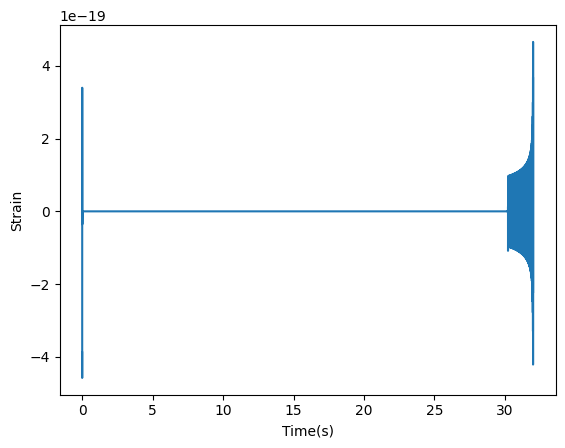

0
32
32.0


In [16]:
m = 20# Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# Resizing the vector to match the data
hp.resize(len(conditioned))
pp.plot(hp.sample_times,hp)
pp.xlim(-2,1)
pp.xlabel('Time(s)')
pp.ylabel('Strain')
pp.show()



print (hp.start_time)
print (hp.end_time)
print (hp.duration)

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# This function rotates the vector by a fixed amount of time.
# It treats the data as if it were on a ring. Note that
# time stamps are *not* in general affected, but the true
# position in the vector is.
#
# By convention, waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position



template = hp.cyclic_time_shift(hp.start_time)
pp.plot(template.sample_times,template)

pp.xlabel('Time(s)')
pp.ylabel('Strain')
pp.show()

print (template.start_time)
print (template.end_time)
print (template.duration)

# Generating SNR time series

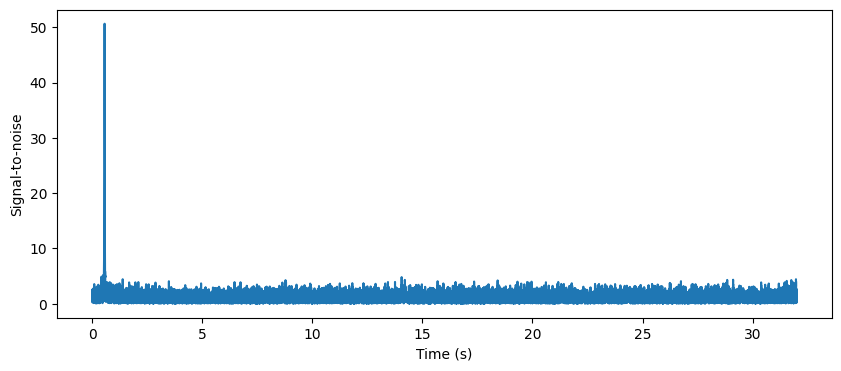

We found a signal at 0.565673828125s with SNR 50.63139496120512


In [9]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=30)



# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.


pp.figure(figsize=[10, 4])
pp.plot(snr.sample_times, abs(snr))
pp.ylabel('Signal-to-noise')
pp.xlabel('Time (s)')
pp.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))